In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
train_transform = transforms.Compose([
	transforms.RandomResizedCrop(224),
	transforms.RandomHorizontalFlip(),
	transforms.RandomRotation(15),
	transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform = transforms.Compose([transforms.ToTensor(),
								transforms.Resize((224, 224))])

In [3]:
training_data = Flowers102(
	root='',
	split='train',
	transform=transform,
	download=True
)

testing_data = Flowers102(
	root='',
	split='test',
	transform=transform,
	download=True
)

evaluation_data = Flowers102(
	root='',
	split='val',
	transform=transform,
	download=True
)

100%|██████████| 344862509/344862509 [00:12<00:00, 28370219.07it/s]


Extracting flowers-102/102flowers.tgz to flowers-102


100%|██████████| 502/502 [00:00<00:00, 496706.91it/s]


100%|██████████| 14989/14989 [00:00<00:00, 14908328.83it/s]


In [4]:
print('Training data has {} instances'.format(len(training_data)))
print('Evaluation data has {} instances'.format(len(evaluation_data)))
print('Testing data has {} instances'.format(len(testing_data)))

Training data has 1020 instances
Evaluation data has 1020 instances
Testing data has 6149 instances


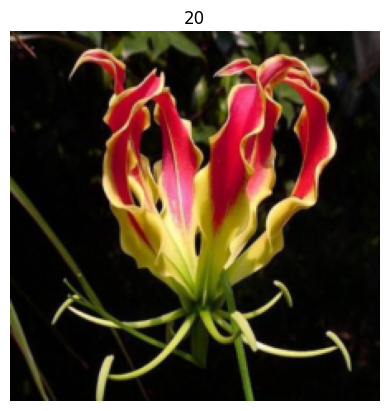

In [5]:
img, label = training_data[160]
np_img = img.permute(1, 2, 0).numpy()
plt.title(label)
plt.imshow((np_img * 255).astype('uint8'))
plt.axis('off')
plt.show()

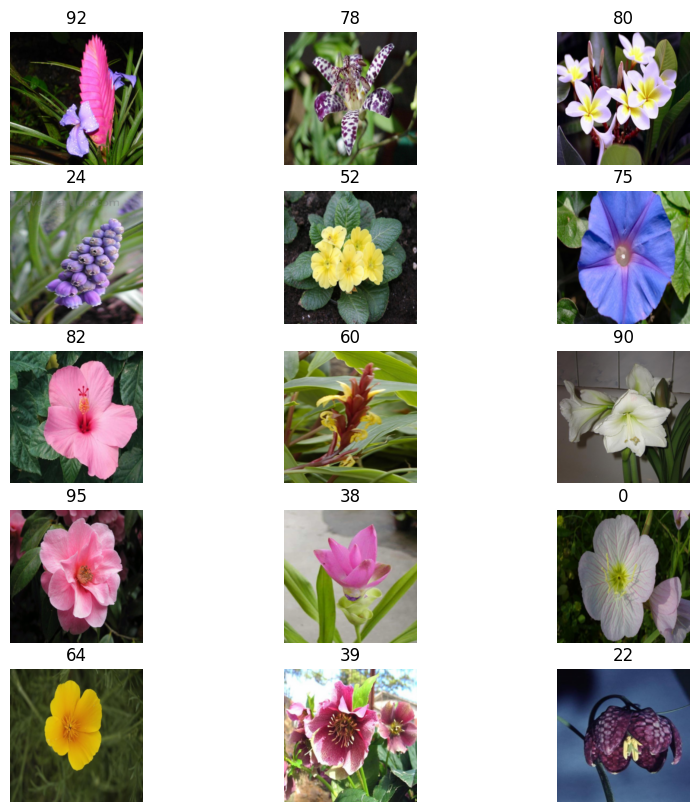

In [6]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 5
for i in range(1, cols * rows + 1):
	sample_idx = torch.randint(len(training_data), size=(1,)).item()
	img, label = training_data[sample_idx]

	np_img = img.permute(1, 2, 0).numpy()
	figure.add_subplot(rows, cols, i)
	plt.title(label)
	plt.imshow((np_img * 255).astype('uint8'))
	plt.axis('off')
plt.show()

In [7]:
# transform simple NN into a CNN
class FlowerClassifier(nn.Module):
	def __init__(self):
			super(FlowerClassifier, self).__init__()
			self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
			self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
			self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
			self.fc1 = nn.Linear(128 * 28 * 28, 512)
			self.fc2 = nn.Linear(512, 102)

	def forward(self, x):
			x = F.relu(F.max_pool2d(self.conv1(x), 2))
			x = F.relu(F.max_pool2d(self.conv2(x), 2))
			x = F.relu(F.max_pool2d(self.conv3(x), 2))
			x = x.view(-1, 128 * 28 * 28)
			x = F.relu(self.fc1(x))
			x = self.fc2(x)
			return F.log_softmax(x, dim=1)

In [8]:
training_loader = DataLoader(training_data, batch_size=64, shuffle=True)
evaluation_loader = DataLoader(evaluation_data, batch_size=64, shuffle=False)

In [9]:
# Check if CUDA is available
if torch.cuda.is_available():
	print("CUDA is available!")
	device = torch.device("cuda")
else:
	print("CUDA is not available. The model will use CPU.")
	device = torch.device("cpu")

CUDA is available!


In [10]:
def train(model, training_loader, evaluation_loader, criterion, optimizer, epochs=10):
	for epoch in range(epochs):
		model.train()
		training_loss = 0.0
		for inputs, labels in training_loader:
			inputs, labels = inputs.to(device), labels.to(device)
			optimizer.zero_grad()
			outputs = model(inputs)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()
			training_loss += loss.item() * inputs.size(0)

		training_loss /= len(training_loader.dataset)

		model.eval()
		evaluation_loss = 0.0
		correct = 0
		total = 0
		with torch.no_grad():
			for inputs, labels in evaluation_loader:
				inputs, labels = inputs.to(device), labels.to(device)
				outputs = model(inputs)
				loss = criterion(outputs, labels)
				evaluation_loss += loss.item() * inputs.size(0)
				_, predicted = torch.max(outputs, 1)
				total += labels.size(0)
				correct += (predicted == labels).sum().item()

		evaluation_loss /= len(evaluation_loader.dataset)
		evaluation_accuracy = correct / total

		print(
			f'Epoch {epoch + 1}/{epochs}, Training Loss: {training_loss:.4f}, Evaluation Loss: {evaluation_loss:.4f}, Val Accuracy: {evaluation_accuracy:.4f}')

In [11]:
model = FlowerClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model, training_loader, evaluation_loader, criterion, optimizer, epochs=25)

Epoch 1/25, Training Loss: 4.7563, Evaluation Loss: 4.6222, Val Accuracy: 0.0108
Epoch 2/25, Training Loss: 4.6050, Evaluation Loss: 4.5386, Val Accuracy: 0.0127
Epoch 3/25, Training Loss: 4.4637, Evaluation Loss: 4.3992, Val Accuracy: 0.0304
Epoch 4/25, Training Loss: 4.1066, Evaluation Loss: 4.1278, Val Accuracy: 0.0569
Epoch 5/25, Training Loss: 3.5986, Evaluation Loss: 4.0492, Val Accuracy: 0.0833
Epoch 6/25, Training Loss: 3.0450, Evaluation Loss: 4.2438, Val Accuracy: 0.0951
Epoch 7/25, Training Loss: 2.2773, Evaluation Loss: 4.5852, Val Accuracy: 0.1206
Epoch 8/25, Training Loss: 1.3611, Evaluation Loss: 4.5364, Val Accuracy: 0.1422
Epoch 9/25, Training Loss: 0.5636, Evaluation Loss: 5.3964, Val Accuracy: 0.1304
Epoch 10/25, Training Loss: 0.2664, Evaluation Loss: 5.9654, Val Accuracy: 0.1451
Epoch 11/25, Training Loss: 0.1265, Evaluation Loss: 6.4095, Val Accuracy: 0.1333
Epoch 12/25, Training Loss: 0.0494, Evaluation Loss: 6.6892, Val Accuracy: 0.1324
Epoch 13/25, Training Los